In [1]:
# import modules
%matplotlib notebook

import numpy as np
from  multiprocessing import Pool

import matplotlib.pyplot as plt
import matplotlib
from cycler import cycler
_colc = cycler(color=[
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
    '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
    '#3f97d4', '#df5f0e', '#106010', '#ff0000', '#aa9900',
    '#0000ff', '#00dd00', '#000000'])
matplotlib.rcParams['axes.prop_cycle'] = _colc
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'

In [2]:
%%time

import chempl
from chempl import (cs, run_one_model, get_total_charge,
                    get_phy_params_default, N_H_to_Av, Av_to_N_H,
                    N_H_to_ngas, Td_from_Av, chem2tex, printFormationDestruction)

phy_params = chempl.get_phy_params_default()

CPU times: user 4.98 ms, sys: 5.46 ms, total: 10.4 ms
Wall time: 578 ms


# define the solver

Here it is called "model".  It acts as a solver.

In [3]:
%%time

model = chempl.ChemModel(
    fReactions=b'rate12_noSurf_only_H2_formation.dat',
    fInitialAbundances=b'initial_abundances.dat').prepare().set_solver()
model.set_phy_params_by_dict(phy_params)

CPU times: user 160 ms, sys: 3.36 ms, total: 163 ms
Wall time: 171 ms


# A simple single run

In [110]:
%%time

t0 = 0.0
dt = 1.0
t_ratio = 1.1
tmax_yr = 1e6
nmax = 2000

res = chempl.run_one_model(
    p={'model_id': 0,
       'y0': model.abundances,
       't0': t0,
       'dt0': dt,
       't_ratio': t_ratio,
       'tmax': tmax_yr*cs.phy_SecondsPerYear,
       'nmax': nmax,
       'phy_params': phy_params
      },
    model=model,
    verbose=False
)

CPU times: user 3.86 s, sys: 49.2 ms, total: 3.91 s
Wall time: 3.91 s


# Define a list of different physical parameter combinations

In [5]:
n_s = np.logspace(3,5,num=16)
phy_params_s = [{b'n_gas': n, b'T_gas': 20.0} for n in n_s]

# Run multiple models one by one

In [7]:
%%time
res0 = chempl.run_multiple_params_sequentially(
    model=model, phy_params_s=phy_params_s, t0=t0, dt0=dt, t_ratio=t_ratio, tmax_yr=tmax_yr, nmax=2000)

CPU times: user 39.4 s, sys: 199 ms, total: 39.6 s
Wall time: 39.4 s


# The same, but ...

using the final state of the previous one as the initial state of the next

In [8]:
%%time
res0 = chempl.run_multiple_params_sequentially(follow=True,
    model=model, phy_params_s=phy_params_s, t0=t0, dt0=dt, t_ratio=t_ratio, tmax_yr=tmax_yr, nmax=2000)

CPU times: user 13.2 s, sys: 92.6 ms, total: 13.3 s
Wall time: 13.2 s


# Try with multiprocessing

In [9]:
def worker(p):
    # Note that the "model" object must be global
    t = p['t0']
    dt = p['dt']
    t_ratio = p['t_ratio']
    nMax = p['nmax']
    tMax = p['tmax']
    
    y = [_ for _ in p['y0']]
    store = {'ts': [], 'ys': []}
    model.set_solver(model_id=p['model_id'])
    model.set_phy_params_by_dict(p['phy_params'])
    for i in range(nMax):
        t, y = model.update(y, t=t, dt=dt, verbose=p.get('verbose'))
        store['ts'].append(t)
        store['ys'].append(y)
        if t >= tMax:
            break
        dt = dt * t_ratio
        if t+dt > tMax:
            dt = tMax - t
    return store

In [10]:
from multiprocessing import Pool
pool = Pool(4)

In [11]:
%%time

p_s = [{'model_id': i,
        'y0': model.abundances,
        't0': t0,
        'dt': dt,
        't_ratio': t_ratio,
        'tmax': tmax_yr*cs.phy_SecondsPerYear,
        'nmax': nmax,
        'phy_params': pps,
        'verbose': False,
      } for (i,pps) in enumerate(phy_params_s)]

res1 = pool.map(worker, p_s)

CPU times: user 143 ms, sys: 64.6 ms, total: 207 ms
Wall time: 13 s


In [12]:
# The results should be the same from sequential or parallel runs

[np.any(np.array(s0['ys'])-np.array(s1['ys'])) for s0,s1 in zip(res0, res1)]

[False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True]

# Investigate the oscillation behavior

In [56]:
reactions_s = sorted(enumerate(model.reactions), key=lambda x: -x[1]['abc'][2])

In [154]:
for ir, r in reactions_s:
    if 5.5e4 <= r['abc'][2] < 5.6e4:
        model.modify_reaction(ir, {b'abc': [0.0, 0.0, 0.0]})

In [160]:
[_ for _ in filter(lambda x: 5.5e4<=x[1]['abc'][2]<5.6e4, reactions_s[:100])]

[(5433,
  {'reactants': [b'N2', b'O2'],
   'products': [b'N2O', b'O'],
   'abc': [1e-10, 0.0, 55200.0],
   'Trange': [1840.0, 41000.0],
   'itype': 5,
   'drdy': [nan, nan],
   'rate': 0.0,
   'heat': 0.0}),
 (141,
  {'reactants': [b'H', b'H2'],
   'products': [b'H', b'H', b'H'],
   'abc': [4.67e-07, -1.0, 55000.0],
   'Trange': [1833.0, 41000.0],
   'itype': 5,
   'drdy': [nan, nan],
   'rate': 0.0,
   'heat': 0.0})]

In [3]:
%%time

model = chempl.ChemModel(
    fReactions=b'rate12_noSurf_only_H2_formation.dat',
    fInitialAbundances=b'initial_abundances.dat').prepare().set_solver()
model.set_phy_params_by_dict(phy_params)
#model.modify_reaction(141, {b'abc': [4.67e-07, -1.0, 55000.0]})
reactions = model.reactions
spe_remove = {b''}
for i in range(len(reactions)):
    if not spe_remove.isdisjoint(set(reactions[i]['reactants']+reactions[i]['products'])):
        model.modify_reaction(i, {b'abc': [0.0, 0.0, 0.0]})

t0 = 0.0
dt = 1.0e2
t_ratio = 1.003
tmax = 1e6*cs.phy_SecondsPerYear
nmax = 8000
y0 = model.abundances

res = chempl.run_one_model(
    p={'model_id': 0,
       'y0': y0,
       't0': t0,
       'dt0': dt,
       't_ratio': t_ratio,
       'tmax': tmax,
       'nmax': nmax,
       'phy_params': {b'n_gas': 1e5,
                      b'T_gas': 1e4,
                      b'T_dust': 10.0,
                      b'G0_UV': 0.0,
                      b'mean_mol_weight': 1.2}
      },
    model=model,
    verbose=True
)
print(len(res['ts']), 'steps')

Solver: 0 finished: 8.519561 seconds elapsed
6900 steps
CPU times: user 8.43 s, sys: 104 ms, total: 8.53 s
Wall time: 8.65 s


In [4]:
%%time

model_noOsc = chempl.ChemModel(
    fReactions=b'rate12_noSurf_only_H2_formation.dat',
    fInitialAbundances=b'initial_abundances.dat').prepare().set_solver()
model_noOsc.set_phy_params_by_dict(phy_params)
model_noOsc.modify_reaction(141, {b'abc': [0.0, 0.0, 0.0]})

t0 = 0.0
dt = 1.0e2
t_ratio = 1.003
tmax = 1e6*cs.phy_SecondsPerYear
nmax = 8000
y0 = model.abundances

res_noOsc = chempl.run_one_model(
    p={'model_id': 0,
       'y0': y0,
       't0': t0,
       'dt0': dt,
       't_ratio': t_ratio,
       'tmax': tmax,
       'nmax': nmax,
       'phy_params': {b'n_gas': 1e5,
                      b'T_gas': 1e4,
                      b'T_dust': 10.0,
                      b'G0_UV': 0.0,
                      b'mean_mol_weight': 1.2}
      },
    model=model_noOsc,
    verbose=True
)

Solver: 0 finished: 4.745612 seconds elapsed
CPU times: user 4.81 s, sys: 76.9 ms, total: 4.89 s
Wall time: 4.86 s


<IPython.core.display.Javascript object>


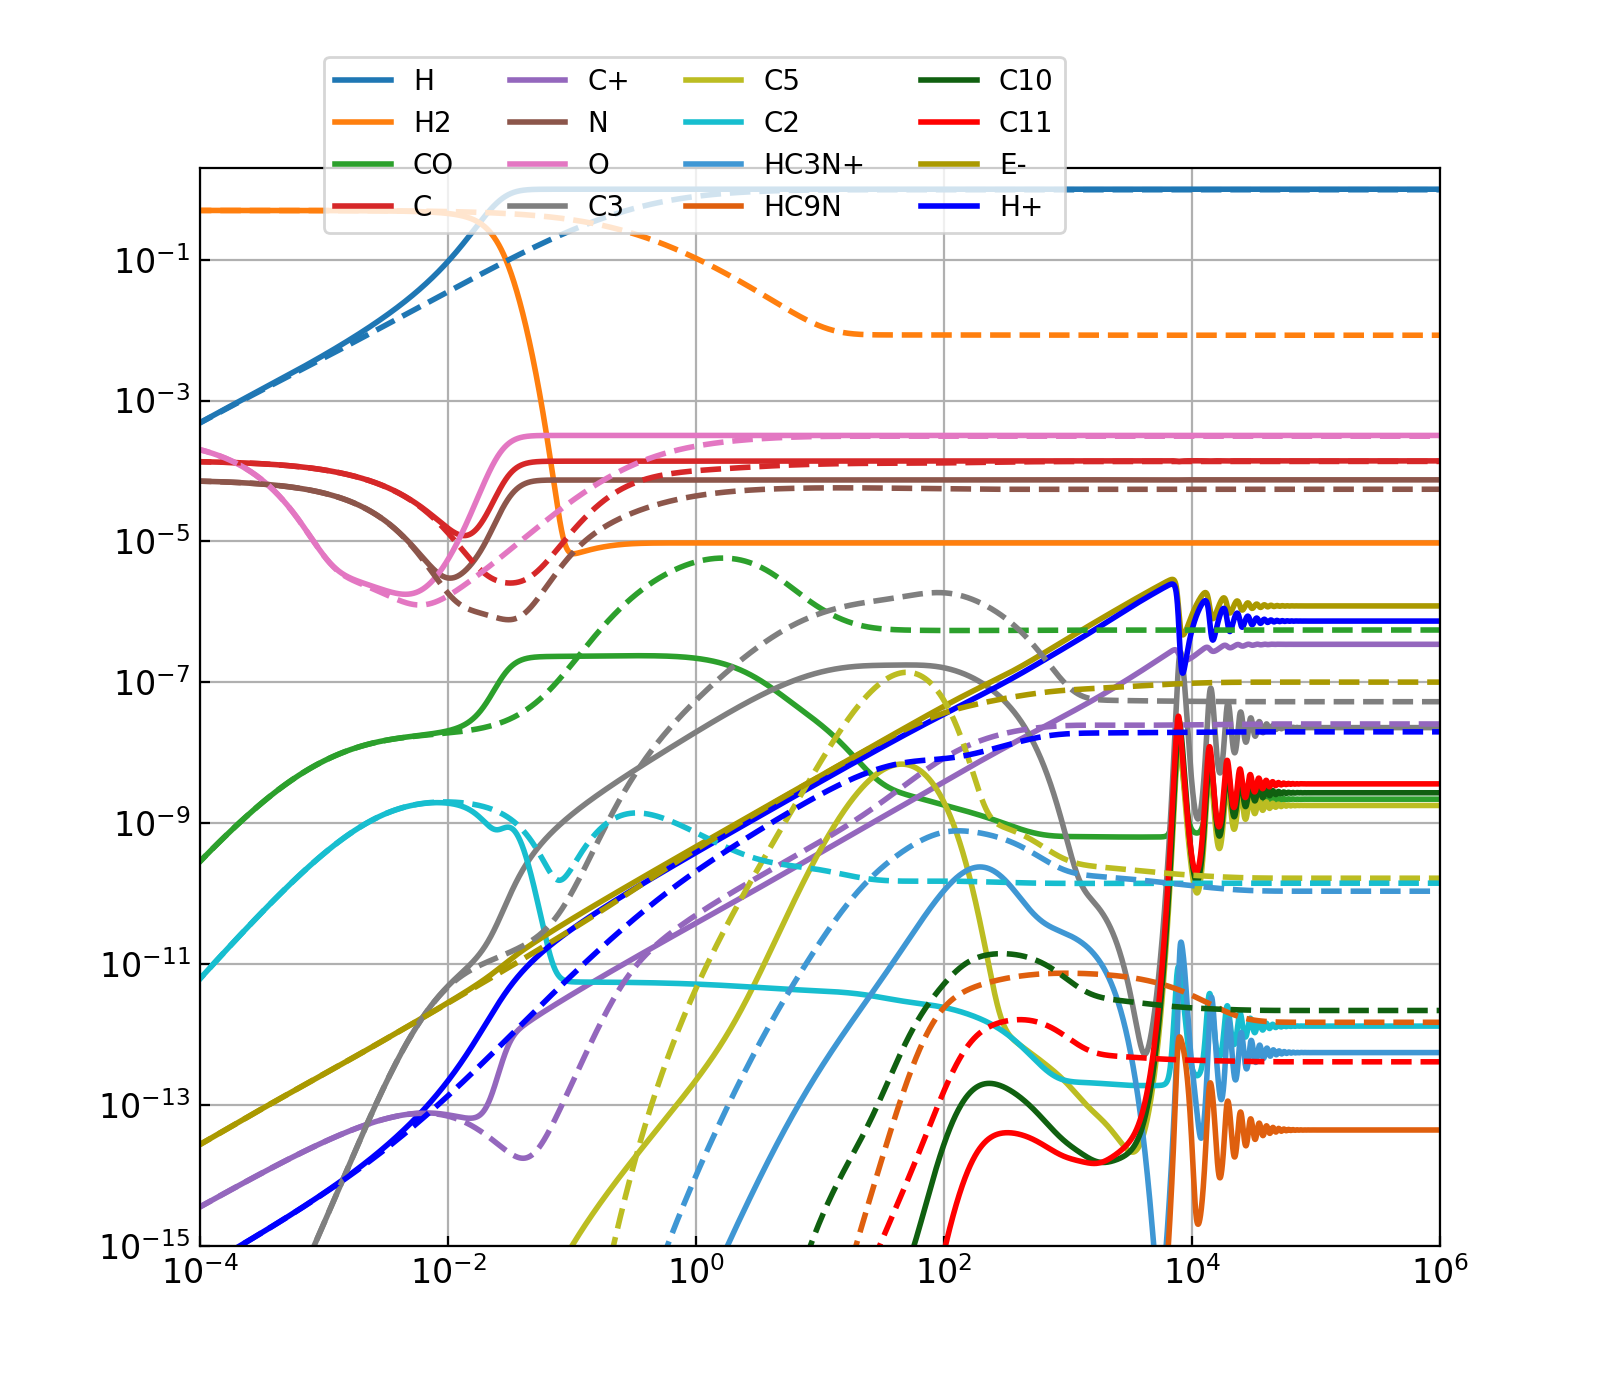

In [5]:
fig = plt.figure(figsize=(8,7))
ax = fig.add_subplot(1,1,1)

t = [_/cs.phy_SecondsPerYear for _ in res['ts']]

spe_s = [b'H', b'H2', b'CO', b'C', b'C+', b'N', b'O',
         b'C3', b'C5', b'C2', b'HC3N+', b'HC9N', b'C10', b'C11', b'E-', b'H+']

for _c,s in zip(_colc, spe_s):
    ax.plot(t, [_[model.name2idx[s]] for _ in res['ys']], color=_c['color'], lw=2, label=s.decode())
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim((1e-4,1e6))
ax.set_ylim((1e-15, 2))
ax.legend(ncol=4, loc=(0.1,0.94), fontsize=10)
ax.grid(which='both')

for _c,s in zip(_colc, spe_s):
    ax.plot(t, [_[model.name2idx[s]] for _ in res_noOsc['ys']], color=_c['color'], lw=2, ls='--')

In [37]:
iH = model.name2idx[b'H']
print(res['ys'][-1][iH], res_noOsc['ys'][-1][iH])

0.9997090305360373 0.9827983873388537


In [74]:
i0,i1,i2 = [np.argmin(np.abs(np.array(res['ts']) - _*cs.phy_SecondsPerYear))
            for _ in [8.1e3, 1.1e4, 1.4e4]]

pvs = []
for i in range(len(model.idx2name)):
    y0 = res['ys'][i0][i]
    y1 = res['ys'][i1][i]
    y2 = res['ys'][i2][i]
    if y0*2<y1 and y1>1.2*y2 and y1>1e-18:
        pvs.append((i, y0, y1, y2))
pvs = sorted(pvs, key=lambda x: -x[1])
for i, y0, y1, y2 in pvs:
        print('{:12s} {:.3e}  {:.3e}'.format(model.idx2name[i].decode(), y0, y1))

E-           5.615e-07  1.315e-06
H+           2.059e-07  9.334e-07
O+           5.495e-11  2.491e-10
O2+          2.459e-11  7.078e-11
OH+          3.922e-12  1.558e-11
H-           1.626e-12  3.807e-12
H2O+         1.726e-13  5.376e-13
H2+          6.717e-14  3.043e-13
HCl+         5.023e-14  1.222e-13
H3+          6.747e-15  1.859e-14
Cl+          1.954e-15  8.859e-15
HeH+         8.640e-16  3.914e-15
O-           5.390e-16  1.262e-15
C-           3.465e-16  8.264e-16


In [70]:
i0,i1,i2 = [np.argmin(np.abs(np.array(res['ts']) - _*cs.phy_SecondsPerYear))
            for _ in [8.1e3, 1.1e4, 1.4e4]]

pvs = []
for i in range(len(model.idx2name)):
    y0 = res['ys'][i0][i]
    y1 = res['ys'][i1][i]
    y2 = res['ys'][i2][i]
    if y0>10*y1 and y1*10<y2 and y1>1e-18:
        pvs.append((i, y0, y1, y2))
pvs = sorted(pvs, key=lambda x: -x[1])
for i, y0, y1, y2 in pvs:
        print('{:12s} {:.3e}  {:.3e}'.format(model.idx2name[i].decode(), y0, y1))

In [39]:
pvs = []
for i in range(len(model.idx2name)):
    y0 = res['ys'][i0][i]
    y1 = res['ys'][i1][i]
    y2 = res['ys'][i2][i]
    if y0>10*y1 and y1*10<y2 and y1>1e-18:
        pvs.append((i, y0, y1, y2))
pvs = sorted(pvs, key=lambda x: -x[1]/x[2])
for i, y0, y1, y2 in pvs:
        print('{:12s} {:.3e}  {:.3e}'.format(model.idx2name[i].decode(), y0, y1))

HC3NH+       9.130e-15  4.777e-18
HC3N+        2.030e-11  3.493e-14
C3N+         1.457e-10  4.844e-13
HC9N         8.268e-13  3.901e-15
C3H3+        3.586e-16  2.249e-18
CH2CCH+      3.940e-16  3.101e-18
C3           2.511e-07  2.008e-09
C3H+         2.915e-10  2.459e-12
C9           1.955e-08  1.681e-10
C4N+         3.774e-13  3.282e-15
SiC3+        2.930e-14  2.993e-16
SiC2H+       1.100e-14  1.231e-16
HC2S+        3.384e-14  4.599e-16
C3H2+        2.453e-16  3.349e-18
C5N+         6.447e-12  8.989e-14
C11+         2.093e-11  2.919e-13
HC5NH+       8.805e-12  1.297e-13
HC7N         2.339e-11  3.484e-13
HC9N+        2.853e-13  4.951e-15
HC5N         2.467e-08  4.343e-10
C3H2         1.684e-15  3.038e-17
C10          1.802e-08  3.270e-10
HNCO         4.716e-16  8.576e-18
C9N          1.239e-09  2.289e-11
SiC4+        9.282e-14  1.732e-15
C2S+         5.791e-13  1.095e-14
C9H          1.903e-08  3.697e-10
C3+          5.793e-09  1.138e-10
C7           4.663e-09  9.392e-11
C4S+         9

In [65]:
for i in range(len(model.idx2name)):
    yOsc = res['ys'][-1][i]
    yNoOsc = res_noOsc['ys'][-1][i]
    if yOsc >= 1e2 * yNoOsc and yNoOsc > 1e-18:
        print('{:12s} {:.3e}  {:.3e}'.format(model.idx2name[i].decode(), yOsc, yNoOsc))

C8           8.576e-10  3.327e-12
C9           1.636e-09  1.105e-11
C10          2.711e-09  2.202e-12
C5-          2.008e-14  1.572e-16
C6-          2.770e-14  1.462e-16
C7-          2.859e-13  4.274e-16
C8-          1.282e-13  4.220e-17
C10-         5.386e-13  3.692e-17
C5H-         2.227e-14  3.884e-17
C6H          2.152e-09  8.982e-12
C6H-         5.622e-14  1.979e-17
C7H          1.894e-09  3.922e-12
C7H-         1.024e-13  1.790e-17
C8H          2.287e-09  1.055e-12
C8H-         2.988e-14  1.164e-18
C9H          2.888e-09  2.689e-12
C9-          1.409e-12  8.032e-16
C9H-         1.217e-13  9.557e-18
C10H         4.166e-09  4.690e-13
C10H2        3.679e-10  3.586e-15
C5H2         2.984e-10  2.057e-12
C5N-         5.425e-15  1.143e-17
C6H2         2.709e-10  9.613e-14
C7H2         6.433e-10  1.131e-13
C8H2         2.371e-10  9.286e-15
C9H2         3.865e-09  3.127e-13
C7N          1.900e-10  3.902e-13
C9N          1.825e-10  1.539e-13
C10H+        2.536e-11  1.963e-14
C2S+         9

In [43]:
for i in range(len(model.idx2name)):
    yOsc = res['ys'][-1][i]
    yNoOsc = res_noOsc['ys'][-1][i]
    if yNoOsc >= 1e2 * yOsc and yOsc > 1e-18:
        print('{:12s} {:.3e}  {:.3e}'.format(model.idx2name[i].decode(), yOsc, yNoOsc))

C2           1.322e-12  1.412e-10
CH2          2.257e-14  1.790e-08
C2H2         6.274e-14  1.929e-09
CH           1.157e-09  1.018e-06
CO           2.198e-09  5.538e-07
H2O          6.394e-14  5.089e-08
CN           2.552e-09  7.456e-07
NH           2.512e-09  1.670e-06
HCN          1.212e-12  3.156e-07
O2           2.678e-13  2.230e-10
OH           8.263e-09  7.281e-06
HCO          5.637e-18  4.492e-12
CS           6.081e-13  1.495e-08
H2           9.522e-06  8.461e-03
NH2          4.994e-15  2.998e-09
H2CCC        3.078e-15  1.533e-12
HC3N         3.197e-11  5.837e-08
HS           2.602e-13  2.790e-08
NO           4.436e-12  2.471e-09
NS           1.453e-17  1.162e-12
C2O          7.912e-16  4.395e-12
SO           1.295e-16  1.076e-11
C2O+         2.361e-18  6.612e-15
C3O          1.997e-16  2.728e-14
C4H3         1.469e-14  2.705e-12
C4H3+        1.288e-13  2.200e-11
CCP          5.527e-17  1.534e-13
CCl+         7.131e-17  5.489e-14
CH2+         2.056e-17  1.188e-12
CH2CCH+      3

In [84]:
chempl.printElementalResidence(b'+', model, res, tmin=1e3, tmax=1.1e3, nstep=30,
                               showFirst=10, showFraction=1e-8)

t = 1.086e+03
0 b'H+' 3.593e-07  0.7802
1 b'S+' 4.327e-08  0.09398
2 b'C+' 3.858e-08  0.08378
3 b'Si+' 4.323e-09  0.009388
4 b'He+' 3.908e-09  0.008488
5 b'Mg+' 3.777e-09  0.008203
6 b'Fe+' 2.972e-09  0.006455
7 b'Na+' 2.007e-09  0.004359
8 b'P+' 1.483e-09  0.003221
9 b'CF+' 5.884e-10  0.001278


In [50]:
chempl.printElementalResidence(b'C', model, res, tmin=6e4, tmax=6.1e4, nstep=20,
                               showFirst=10, showFraction=1e-8)

t = 6.011e+04
0 b'C' 1.393e-04  0.9947
1 b'C+' 3.470e-07  0.002479
2 b'C3' 6.955e-08  0.0004968
3 b'C10H' 4.231e-08  0.0003022
4 b'C11' 4.051e-08  0.0002894
5 b'C9H2' 3.531e-08  0.0002522
6 b'C10' 2.756e-08  0.0001968
7 b'C9H' 2.641e-08  0.0001887
8 b'HC5N' 1.887e-08  0.0001348
9 b'C8H' 1.857e-08  0.0001326


In [47]:
chempl.printElementalResidence(b'C', model, res, tmin=2e3, tmax=2.2e3, nstep=20,
                               showFirst=10, showFraction=1e-8)

t = 2.098e+03
0 b'C' 1.399e-04  0.9994
1 b'C+' 7.437e-08  0.0005312
2 b'HC3N' 6.827e-09  4.876e-05
3 b'CN' 1.200e-09  8.568e-06
4 b'CH' 1.161e-09  8.296e-06
5 b'CO' 6.415e-10  4.582e-06
6 b'CF+' 5.717e-10  4.083e-06
7 b'CH2NH' 2.279e-10  1.628e-06
8 b'C3' 1.168e-10  8.342e-07
9 b'HC5N' 6.542e-11  4.673e-07


In [99]:
chempl.printFormationDestruction(b'H2', model, res, tmin=0.05, tmax=0.051, nstep=5,
                              showFirst=10, showFraction=0.001)

Time      total_f   total_d   tscale_n  tscale_f tscale_d Tg       Td    ngas     y        tidx
5.024e-02 3.455e-10 1.646e-08 -5.59e-03 2.61e-01 5.47e-03 10000.00 10.00 1.00e+05 2.84e-03 1295
2.723e-10 H + OH  ->  O + H2 [6.99e-14, 2.8, 1950.0] 5411
2.291e-11 gH2  ->  H2 [1.0, 0.0, 430.0] 6176
1.702e-11 H + NH  ->  N + H2 [1.73e-11, 0.5, 2400.0] 5397
1.216e-11 H + CH  ->  C + H2 [1.31e-10, 0.0, 80.0] 5373
9.675e-12 H + CH2  ->  CH + H2 [2.2e-10, 0.0, 0.0] 5369
7.448e-12 H + CH3  ->  CH2 + H2 [1e-10, 0.0, 7600.0] 5371
1.797e-12 H2 + H2  ->  H2 + H + H [1e-08, 0.0, 84100.0] 134
1.091e-12 H + C2H2  ->  C2H + H2 [3.8e-10, 0.0, 13634.0] 5367
3.311e-13 H + H2O  ->  OH + H2 [1.59e-11, 1.2, 9610.0] 5381
2.913e-13 H + CH4  ->  CH3 + H2 [5.94e-13, 3.0, 4045.0] 5372
-1.617e-08 H + H2  ->  H + H + H [4.67e-07, -1.0, 55000.0] 141
-2.671e-10 H2 + O  ->  OH + H [3.14e-13, 2.7, 3150.0] 5360


In [100]:
chempl.printFormationDestruction(b'H2', model_noOsc, res_noOsc, tmin=0.05, tmax=0.051, nstep=5,
                              showFirst=10, showFraction=0.001)

Time      total_f   total_d   tscale_n  tscale_f tscale_d Tg       Td    ngas     y        tidx
5.024e-02 4.717e-08 4.765e-08 -2.82e+01 2.85e-01 2.82e-01 10000.00 10.00 1.00e+05 4.23e-01 1295
3.992e-08 H2 + H2  ->  H2 + H + H [1e-08, 0.0, 84100.0] 134
2.417e-09 H + CH4  ->  CH3 + H2 [5.94e-13, 3.0, 4045.0] 5372
1.651e-09 H + OH  ->  O + H2 [6.99e-14, 2.8, 1950.0] 5411
1.258e-09 H + NH3  ->  NH2 + H2 [7.8e-13, 2.4, 4990.0] 5396
1.256e-09 H + H2O  ->  OH + H2 [1.59e-11, 1.2, 9610.0] 5381
2.504e-10 H2 + H2O  ->  OH + H2 + H [5.8e-09, 0.0, 52900.0] 135
1.610e-10 H2 + OH  ->  O + H2 + H [6e-09, 0.0, 50900.0] 138
8.546e-11 H + CH2  ->  CH + H2 [2.2e-10, 0.0, 0.0] 5369
6.380e-11 H + CH3  ->  CH2 + H2 [1e-10, 0.0, 7600.0] 5371
-3.992e-08 H2 + H2  ->  H2 + H + H [1e-08, 0.0, 84100.0] 134
-2.417e-09 H2 + CH3  ->  CH4 + H [6.86e-14, 2.74, 4740.0] 5349
-1.857e-09 H2 + O  ->  OH + H [3.14e-13, 2.7, 3150.0] 5360
-1.550e-09 H2 + OH  ->  H2O + H [2.05e-12, 1.52, 1736.0] 5361
-1.240e-09 H2 + NH2  ->  N

In [11]:
chempl.printFormationDestruction(b'H+', model, res, tmin=6e3, tmax=6.1e3, nstep=9,
                              showFirst=10, showFraction=0.00001)

Time      total_f   total_d   tscale_n tscale_f tscale_d Tg       Td    ngas     y        tidx
6.041e+03 1.201e-13 1.201e-13 6.29e+03 5.93e-01 5.93e-01 10000.00 10.00 1.00e+05 2.25e-06 5193
1.200e-13 H + O+  ->  O + H+ [5.66e-10, 0.36, -8.6] 491
4.686e-17 H + H2+  ->  H2 + H+ [6.4e-10, 0.0, 0.0] 488
6.498e-18 H  ->  H+ + E- [1.3e-17, 0.0, 0.2] 893
5.978e-18 H  ->  H+ + E- [5.98e-18, 0.0, 0.0] 732
-1.200e-13 H+ + O  ->  O+ + H [6.86e-10, 0.26, 224.3] 405
-4.692e-17 H+ + H  ->  H2+ [1.15e-18, 1.49, 228.0] 6092


In [100]:
chempl.printFormationDestruction(b'C2', model_noOsc, res_noOsc, tmin=1e3, tmax=1.1e3, nstep=30,
                              showFirst=10, showFraction=0.001)

Time      total_f   total_d   tscale_n  tscale_f tscale_d Tg       Td    ngas     y        tidx
1.086e+03 1.768e-15 1.768e-15 -2.97e+05 2.51e-03 2.51e-03 10000.00 10.00 1.00e+05 1.40e-10 4620
9.106e-16 C + CH  ->  C2 + H [6.59e-11, 0.0, 0.0] 5172
8.227e-16 C + CN  ->  C2 + N [4.98e-10, 0.0, 18116.0] 5173
1.682e-17 CN + CN  ->  N2 + C2 [2.66e-09, 0.0, 21638.0] 5326
1.108e-17 O + C3  ->  CO + C2 [5e-12, 0.0, 900.0] 5567
3.854e-18 C + CO  ->  C2 + O [2.94e-11, 0.5, 58025.0] 5174
2.195e-18 C + CS  ->  S + C2 [1.44e-11, 0.5, 20435.0] 5175
-1.768e-15 H + C2  ->  CH + C [4.67e-10, 0.5, 30450.0] 5366


In [106]:
chempl.printFormationDestruction(b'C2', model, res, tmin=7e3, tmax=7.1e3, nstep=5,
                              showFirst=10, showFraction=0.001)

Time      total_f   total_d   tscale_n tscale_f tscale_d Tg       Td    ngas     y        tidx
7.059e+03 1.472e-17 1.472e-17 2.54e+02 2.47e-03 2.47e-03 10000.00 10.00 1.00e+05 1.15e-12 5245
5.915e-18 C3+ + E-  ->  C2 + C [3e-07, -0.5, 0.0] 1040
2.387e-18 C + CN  ->  C2 + N [4.98e-10, 0.0, 18116.0] 5173
1.292e-18 C5+ + E-  ->  C3 + C2 [3e-07, -0.5, 0.0] 1090
1.064e-18 C + CH  ->  C2 + H [6.59e-11, 0.0, 0.0] 5172
8.962e-19 O + C3  ->  CO + C2 [5e-12, 0.0, 900.0] 5567
6.053e-19 C10+ + E-  ->  C8 + C2 [1e-06, -0.3, 0.0] 985
4.539e-19 C9+ + E-  ->  C7 + C2 [1e-06, -0.3, 0.0] 1140
4.055e-19 C8+ + E-  ->  C6 + C2 [1e-06, -0.3, 0.0] 1128
3.749e-19 C6+ + E-  ->  C4 + C2 [1e-06, -0.3, 0.0] 1100
2.984e-19 C7+ + E-  ->  C5 + C2 [1e-06, -0.3, 0.0] 1115
-1.471e-17 H + C2  ->  CH + C [4.67e-10, 0.5, 30450.0] 5366


In [14]:
chempl.printFormationDestruction(b'C3', model, res, tmin=7e3, tmax=7.1e3, nstep=5,
                              showFirst=10, showFraction=0.001)

Time      total_f   total_d   tscale_n tscale_f tscale_d Tg       Td    ngas     y        tidx
7.059e+03 7.892e-18 6.950e-18 2.06e+02 2.46e+01 2.80e+01 10000.00 10.00 1.00e+05 6.13e-09 5245
3.162e-18 C + C5  ->  C3 + C3 [1.2e-10, 0.0, 0.0] 5143
1.292e-18 C5+ + E-  ->  C3 + C2 [3e-07, -0.5, 0.0] 1090
1.221e-18 C10H+ + E-  ->  C7H + C3 [3.92e-07, -0.3, 0.0] 989
7.724e-19 C + C7  ->  C3 + C5 [1.4e-10, 0.0, 0.0] 5151
4.539e-19 O + C4  ->  C3 + CO [1e-10, 0.0, 0.0] 5572
2.483e-19 C + C6  ->  C3 + C4 [5e-11, 0.0, 0.0] 5148
1.780e-19 C + C4  ->  C2 + C3 [9e-11, 0.0, 0.0] 5140
1.339e-19 C11+ + E-  ->  C8 + C3 [1.2e-06, -0.3, 0.0] 995
1.183e-19 C4+ + E-  ->  C3 + C [1.8e-07, -0.5, 0.0] 1072
1.063e-19 N + C4  ->  C3 + CN [1e-10, 0.0, 0.0] 5448
-6.044e-18 H+ + C3  ->  C3+ + H [4e-09, 0.0, 0.0] 332
-8.962e-19 O + C3  ->  CO + C2 [5e-12, 0.0, 900.0] 5567


In [7]:
chempl.printFormationDestruction(b'C3', model_noOsc, res_noOsc, tmin=6e3, tmax=6.1e3, nstep=9,
                              showFirst=10, showFraction=0.001)

Time      total_f   total_d   tscale_n  tscale_f tscale_d Tg       Td    ngas     y        tidx
6.041e+03 8.338e-18 8.344e-18 -3.12e+05 2.06e+02 2.06e+02 10000.00 10.00 1.00e+05 5.43e-08 5193
4.054e-18 C + C2H  ->  C3 + H [1e-10, 0.0, 0.0] 5133
2.520e-18 C + C2H2  ->  C3 + H2 [1.45e-10, -0.12, 0.0] 5128
6.430e-19 C + C5  ->  C3 + C3 [1.2e-10, 0.0, 0.0] 5143
5.621e-19 O + C4  ->  C3 + CO [1e-10, 0.0, 0.0] 5572
2.214e-19 C + C4  ->  C2 + C3 [9e-11, 0.0, 0.0] 5140
1.710e-19 C3H+ + E-  ->  C3 + H [1.5e-07, -0.5, 0.0] 1042
9.914e-20 N + C4  ->  C3 + CN [1e-10, 0.0, 0.0] 5448
3.355e-20 C + C7  ->  C3 + C5 [1.4e-10, 0.0, 0.0] 5151
2.456e-20 C + C6  ->  C3 + C4 [5e-11, 0.0, 0.0] 5148
8.767e-21 O + C4H+  ->  C3 + HCO+ [2e-10, 0.0, 0.0] 3918
-7.739e-18 O + C3  ->  CO + C2 [5e-12, 0.0, 900.0] 5567
-4.220e-19 H+ + C3  ->  C3+ + H [4e-09, 0.0, 0.0] 332
-1.429e-19 H3O+ + C3  ->  C3H+ + H2O [2e-09, 0.0, 0.0] 2990
-2.987e-20 N + C3  ->  CN + C2 [1e-13, 0.0, 0.0] 5444


In [15]:
chempl.printFormationDestruction(b'C5', model, res, tmin=5e3, tmax=5.1e3, nstep=9,
                              showFirst=10, showFraction=0.001)

Time      total_f   total_d   tscale_n tscale_f tscale_d Tg       Td    ngas     y        tidx
5.002e+03 1.161e-21 1.135e-21 3.57e+02 8.08e+00 8.26e+00 10000.00 10.00 1.00e+05 2.96e-13 5130
3.246e-22 O + C6  ->  C5 + CO [1e-10, 0.0, 0.0] 5579
2.537e-22 C + C4H  ->  C5 + H [1e-10, 0.0, 0.0] 5142
2.446e-22 C + C7  ->  C3 + C5 [1.4e-10, 0.0, 0.0] 5151
7.604e-23 N + C6  ->  CN + C5 [1e-10, 0.0, 0.0] 5455
7.485e-23 C6+ + E-  ->  C5 + C [1e-06, -0.3, 0.0] 1101
7.090e-23 C + C6  ->  C2 + C5 [5e-11, 0.0, 0.0] 5147
6.619e-23 C7+ + E-  ->  C5 + C2 [1e-06, -0.3, 0.0] 1115
3.275e-23 C10H+ + E-  ->  C5H + C5 [5.4e-08, -0.3, 0.0] 988
1.115e-23 C5H+ + E-  ->  C5 + H [3e-07, -0.5, 0.0] 1092
2.192e-24 C + C10-  ->  C5 + C6 + E- [1e-09, 0.0, 0.0] 37
-4.960e-22 C + C5  ->  C3 + C3 [1.2e-10, 0.0, 0.0] 5143
-3.687e-22 C5 + E-  ->  C5- [3.3e-08, -0.5, 0.0] 6142
-2.205e-22 H+ + C5  ->  C5+ + H [4e-09, 0.0, 0.0] 342
-4.324e-23 O + C5  ->  C4 + CO [5e-12, 0.0, 900.0] 5576
-5.728e-24 C+ + C5  ->  C6+ [1e-09, 0.

In [16]:
chempl.printFormationDestruction(b'C6', model, res, tmin=5e3, tmax=5.1e3, nstep=9,
                              showFirst=10, showFraction=0.001)

Time      total_f   total_d   tscale_n tscale_f tscale_d Tg       Td    ngas     y        tidx
5.002e+03 1.281e-21 1.272e-21 3.48e+02 2.51e+00 2.53e+00 10000.00 10.00 1.00e+05 1.01e-13 5130
1.019e-21 C + C5H  ->  C6 + H [1e-10, 0.0, 0.0] 5145
8.614e-23 C8+ + E-  ->  C6 + C2 [1e-06, -0.3, 0.0] 1128
6.619e-23 C7+ + E-  ->  C6 + C [1e-06, -0.3, 0.0] 1116
5.183e-23 O + C7N  ->  C6 + OCN [4e-11, 0.0, 0.0] 5583
2.844e-23 C6H+ + E-  ->  C6 + H [1e-06, -0.3, 0.0] 1103
1.827e-23 O + C7  ->  C6 + CO [5e-12, 0.0, 900.0] 5581
4.244e-24 C6H2+ + E-  ->  C6 + H2 [1e-06, -0.3, 0.0] 1104
2.541e-24 O + C7H+  ->  C6 + HCO+ [2e-10, 0.0, 0.0] 3932
2.192e-24 C + C10-  ->  C5 + C6 + E- [1e-09, 0.0, 0.0] 37
1.740e-24 C11+ + E-  ->  C6 + C5 [8.39e-08, -0.3, 0.0] 993
-6.516e-22 C6 + E-  ->  C6- [1.7e-07, -0.5, 0.0] 6145
-3.246e-22 O + C6  ->  C5 + CO [1e-10, 0.0, 0.0] 5579
-7.604e-23 N + C6  ->  CN + C5 [1e-10, 0.0, 0.0] 5455
-7.564e-23 H+ + C6  ->  C6+ + H [4e-09, 0.0, 0.0] 345
-7.090e-23 C + C6  ->  C3 + C4 [

In [17]:
chempl.printFormationDestruction(b'C5H', model, res, tmin=5e3, tmax=5.1e3, nstep=9,
                              showFirst=10, showFraction=0.001)

Time      total_f   total_d   tscale_n tscale_f tscale_d Tg       Td    ngas     y        tidx
5.002e+03 2.855e-21 2.786e-21 3.36e+02 8.09e+00 8.29e+00 10000.00 10.00 1.00e+05 7.29e-13 5130
1.983e-21 C + C10H2  ->  C5H + C6H [1e-09, 0.0, 0.0] 5126
3.695e-22 O + C6H  ->  C5H + CO [1.7e-11, 0.0, 0.0] 5580
3.686e-22 H + C5-  ->  C5H + E- [6.2e-10, 0.0, 0.0] 93
6.953e-23 C + HC4H  ->  C5H + H [6.5e-10, 0.0, 0.0] 5178
3.275e-23 C10H+ + E-  ->  C5H + C5 [5.4e-08, -0.3, 0.0] 988
2.844e-23 C6H+ + E-  ->  C5H + C [1e-06, -0.3, 0.0] 1102
2.118e-24 C5H2+ + E-  ->  C5H + H [1.5e-07, -0.5, 0.0] 1094
-1.129e-21 C5H + E-  ->  C5H- [4.1e-08, -0.5, 0.0] 6143
-1.019e-21 C + C5H  ->  C6 + H [1e-10, 0.0, 0.0] 5145
-3.964e-22 O + C5H  ->  C4H + CO [1.7e-11, 0.0, 0.0] 5577
-9.287e-23 N + C5H  ->  C5N + H [1.7e-11, 0.0, 0.0] 5453
-7.060e-23 H+ + C5H  ->  C5H+ + H [3e-09, -0.5, 0.0] 344
-7.060e-23 H+ + C5H  ->  C5+ + H2 [3e-09, -0.5, 0.0] 2524
-7.335e-24 C+ + C5H  ->  C6+ + H [3e-09, -0.5, 0.0] 1544


In [18]:
chempl.printFormationDestruction(b'C10H2', model, res, tmin=5e3, tmax=5.1e3, nstep=9,
                              showFirst=10, showFraction=0.001)

Time      total_f   total_d   tscale_n tscale_f tscale_d Tg       Td    ngas     y        tidx
5.002e+03 2.109e-21 2.095e-21 3.23e+02 2.13e+00 2.15e+00 10000.00 10.00 1.00e+05 1.42e-13 5130
2.109e-21 H + C10H-  ->  C10H2 + E- [1e-09, 0.0, 0.0] 85
-1.983e-21 C + C10H2  ->  C5H + C6H [1e-09, 0.0, 0.0] 5126
-5.288e-23 H+ + C10H2  ->  C10H2+ + H [2e-09, 0.0, 0.0] 320
-5.288e-23 H+ + C10H2  ->  C10H+ + H2 [2e-09, 0.0, 0.0] 2513
-6.594e-24 C+ + C10H2  ->  C11+ + H2 [2.4e-09, 0.0, 0.0] 1516


In [19]:
chempl.printFormationDestruction(b'C10H-', model, res, tmin=5e3, tmax=5.1e3, nstep=9,
                              showFirst=10, showFraction=0.001)

Time      total_f   total_d   tscale_n tscale_f tscale_d Tg       Td    ngas     y        tidx
5.002e+03 2.110e-21 2.110e-21 3.21e+02 3.17e-04 3.17e-04 10000.00 10.00 1.00e+05 2.11e-17 5130
2.110e-21 C10H + E-  ->  C10H- [6e-08, -0.5, 0.0] 6134
-2.109e-21 H + C10H-  ->  C10H2 + E- [1e-09, 0.0, 0.0] 85


In [20]:
chempl.printFormationDestruction(b'C10H', model, res, tmin=5e3, tmax=5.1e3, nstep=9,
                              showFirst=10, showFraction=0.001)

Time      total_f   total_d   tscale_n tscale_f tscale_d Tg       Td    ngas     y        tidx
5.002e+03 6.533e-21 6.447e-21 3.43e+02 4.52e+00 4.58e+00 10000.00 10.00 1.00e+05 9.31e-13 5130
3.666e-21 C + C9H2  ->  C10H + H [2.9e-10, -0.08, 0.0] 5158
2.822e-21 H + C10-  ->  C10H + E- [1.8e-10, 0.0, 0.0] 84
4.410e-23 C10H2+ + E-  ->  C10H + H [1.35e-06, -0.3, 0.0] 990
-2.602e-21 C + C10H  ->  C11 + H [2e-10, 0.0, 0.0] 5127
-2.110e-21 C10H + E-  ->  C10H- [6e-08, -0.5, 0.0] 6134
-1.196e-21 H+ + C10H  ->  C10H+ + H [3.98e-08, -0.5, 0.0] 321
-5.062e-22 O + C10H  ->  C9H + CO [1.7e-11, 0.0, 0.0] 5552
-1.561e-23 C+ + C10H  ->  C10H+ + C [5e-09, -0.5, 0.0] 146
-1.483e-23 C+ + C10H  ->  C11+ + H [4.75e-09, -0.5, 0.0] 1517


In [21]:
chempl.printFormationDestruction(b'C9H2', model, res, tmin=5e3, tmax=5.1e3, nstep=9,
                              showFirst=10, showFraction=0.001)

Time      total_f   total_d   tscale_n tscale_f tscale_d Tg       Td    ngas     y        tidx
5.002e+03 3.996e-21 3.881e-21 3.30e+02 9.50e+00 9.78e+00 10000.00 10.00 1.00e+05 1.20e-12 5130
3.996e-21 H + C9H-  ->  C9H2 + E- [1e-09, 0.0, 0.0] 103
-3.666e-21 C + C9H2  ->  C10H + H [2.9e-10, -0.08, 0.0] 5158
-9.665e-23 H+ + C9H2  ->  C9H2+ + H [2.5e-09, -0.5, 0.0] 355
-9.665e-23 H+ + C9H2  ->  C9H+ + H2 [2.5e-09, -0.5, 0.0] 2531
-1.155e-23 C+ + C9H2  ->  C10H+ + H [4.98e-10, 0.0, 0.0] 1558
-9.641e-24 C+ + C9H2  ->  C10+ + H2 [2.4e-09, -0.5, 0.0] 1557


In [22]:
chempl.printFormationDestruction(b'C9H-', model, res, tmin=5e3, tmax=5.1e3, nstep=9,
                              showFirst=10, showFraction=0.001)

Time      total_f   total_d   tscale_n tscale_f tscale_d Tg       Td    ngas     y        tidx
5.002e+03 3.998e-21 3.998e-21 3.28e+02 3.17e-04 3.17e-04 10000.00 10.00 1.00e+05 4.00e-17 5130
3.997e-21 C9H + E-  ->  C9H- [2e-07, -0.5, 0.0] 6152
-3.996e-21 H + C9H-  ->  C9H2 + E- [1e-09, 0.0, 0.0] 103


In [23]:
chempl.printFormationDestruction(b'C9H', model, res, tmin=5e3, tmax=5.1e3, nstep=9,
                              showFirst=10, showFraction=0.001)

Time      total_f   total_d   tscale_n tscale_f tscale_d Tg       Td    ngas     y        tidx
5.002e+03 6.006e-21 5.958e-21 3.50e+02 2.79e+00 2.81e+00 10000.00 10.00 1.00e+05 5.29e-13 5130
3.847e-21 H + C9-  ->  C9H + E- [1.22e-10, 0.0, 0.0] 102
1.610e-21 C + C8H2  ->  C9H + H [9e-10, 0.0, 0.0] 5156
5.062e-22 O + C10H  ->  C9H + CO [1.7e-11, 0.0, 0.0] 5552
4.061e-23 C9H2+ + E-  ->  C9H + H [1e-06, -0.3, 0.0] 1145
-3.997e-21 C9H + E-  ->  C9H- [2e-07, -0.5, 0.0] 6152
-1.479e-21 C + C9H  ->  C10 + H [2e-10, 0.0, 0.0] 5159
-2.877e-22 O + C9H  ->  C8H + CO [1.7e-11, 0.0, 0.0] 5587
-6.741e-23 N + C9H  ->  C9N + H [1.7e-11, 0.0, 0.0] 5464
-5.978e-23 H+ + C9H  ->  C9H+ + H [3.5e-09, -0.5, 0.0] 356
-5.978e-23 H+ + C9H  ->  C9+ + H2 [3.5e-09, -0.5, 0.0] 2532
-7.099e-24 C+ + C9H  ->  C10+ + H [4e-09, -0.5, 0.0] 1559


In [24]:
chempl.printFormationDestruction(b'C9-', model, res, tmin=5e3, tmax=5.1e3, nstep=9,
                              showFirst=10, showFraction=0.001)

Time      total_f   total_d   tscale_n tscale_f tscale_d Tg       Td    ngas     y        tidx
5.002e+03 3.858e-21 3.858e-21 3.42e+02 2.59e-03 2.59e-03 10000.00 10.00 1.00e+05 3.15e-16 5130
3.855e-21 C9 + E-  ->  C9- [5e-07, -0.5, 0.0] 6151
-3.847e-21 H + C9-  ->  C9H + E- [1.22e-10, 0.0, 0.0] 102
-5.046e-24 O + C9-  ->  CO + C8- [5e-10, 0.0, 0.0] 3940
-4.409e-24 C + C9-  ->  C10 + E- [1e-09, 0.0, 0.0] 53


In [25]:
chempl.printFormationDestruction(b'C9', model, res, tmin=5e3, tmax=5.1e3, nstep=9,
                              showFirst=10, showFraction=0.001)

Time      total_f   total_d   tscale_n tscale_f tscale_d Tg       Td    ngas     y        tidx
5.002e+03 4.059e-21 4.041e-21 3.66e+02 1.59e+00 1.60e+00 10000.00 10.00 1.00e+05 2.04e-13 5130
1.957e-21 C + C8H  ->  C9 + H [2e-10, 0.0, 0.0] 5157
1.408e-21 O + C10  ->  CO + C9 [1e-10, 0.0, 0.0] 5551
3.299e-22 N + C10  ->  CN + C9 [1e-10, 0.0, 0.0] 5434
1.393e-22 C10+ + E-  ->  C9 + C [1e-06, -0.3, 0.0] 986
1.299e-22 C9H+ + E-  ->  C9 + H [1e-06, -0.3, 0.0] 1143
4.061e-23 C9H2+ + E-  ->  C9 + H2 [1e-06, -0.3, 0.0] 1144
3.820e-23 O + C10H+  ->  C9 + HCO+ [1.5e-10, 0.0, 0.0] 3898
1.402e-23 C11+ + E-  ->  C9 + C2 [6.76e-07, -0.3, 0.0] 996
-3.855e-21 C9 + E-  ->  C9- [5e-07, -0.5, 0.0] 6151
-1.522e-22 H+ + C9  ->  C9+ + H [4e-09, 0.0, 0.0] 354
-2.983e-23 O + C9  ->  C8 + CO [5e-12, 0.0, 900.0] 5586
-3.953e-24 C+ + C9  ->  C10+ [1e-09, 0.0, 0.0] 6048


In [26]:
chempl.printFormationDestruction(b'C8H', model, res, tmin=5e3, tmax=5.1e3, nstep=9,
                              showFirst=10, showFraction=0.001)

Time      total_f   total_d   tscale_n tscale_f tscale_d Tg       Td    ngas     y        tidx
5.002e+03 4.663e-21 4.597e-21 3.33e+02 4.76e+00 4.83e+00 10000.00 10.00 1.00e+05 7.00e-13 5130
3.267e-21 C + C7H2  ->  C8H + H [8.4e-10, 0.0, 0.0] 5152
9.707e-22 H + C8-  ->  C8H + E- [2.41e-10, 0.0, 0.0] 100
2.877e-22 O + C9H  ->  C8H + CO [1.7e-11, 0.0, 0.0] 5587
1.299e-22 C9H+ + E-  ->  C8H + C [1e-06, -0.3, 0.0] 1142
3.793e-24 C8H2+ + E-  ->  C8H + H [1e-06, -0.3, 0.0] 1133
3.411e-24 O + C9H2+  ->  C8H + HCO+ [2e-10, 0.0, 0.0] 3943
-1.957e-21 C + C8H  ->  C9 + H [2e-10, 0.0, 0.0] 5157
-1.640e-21 C8H + E-  ->  C8H- [6.2e-08, -0.5, 0.0] 6150
-5.248e-22 N + C8H  ->  CN + C7H [1e-10, 0.0, 0.0] 5462
-3.808e-22 O + C8H  ->  C7H + CO [1.7e-11, 0.0, 0.0] 5585
-4.521e-23 H+ + C8H  ->  C8H+ + H [2e-09, -0.5, 0.0] 353
-4.521e-23 H+ + C8H  ->  C8+ + H2 [2e-09, -0.5, 0.0] 2530
-3.288e-24 C+ + C8H  ->  C9+ + H [1.4e-09, -0.5, 0.0] 1556


In [27]:
chempl.printFormationDestruction(b'C7H2', model, res, tmin=5e3, tmax=5.1e3, nstep=9,
                              showFirst=10, showFraction=0.001)

Time      total_f   total_d   tscale_n tscale_f tscale_d Tg       Td    ngas     y        tidx
5.002e+03 3.341e-21 3.314e-21 3.21e+02 2.64e+00 2.66e+00 10000.00 10.00 1.00e+05 2.78e-13 5130
3.341e-21 H + C7H-  ->  C7H2 + E- [7.4e-10, 0.0, 0.0] 99
-3.267e-21 C + C7H2  ->  C8H + H [8.4e-10, 0.0, 0.0] 5152
-2.246e-23 H+ + C7H2  ->  C7H2+ + H [2.5e-09, -0.5, 0.0] 349
-2.246e-23 H+ + C7H2  ->  C7H+ + H2 [2.5e-09, -0.5, 0.0] 2527


In [28]:
chempl.printFormationDestruction(b'C7H-', model, res, tmin=5e3, tmax=5.1e3, nstep=9,
                              showFirst=10, showFraction=0.001)

Time      total_f   total_d   tscale_n tscale_f tscale_d Tg       Td    ngas     y        tidx
5.002e+03 3.343e-21 3.343e-21 3.20e+02 4.28e-04 4.28e-04 10000.00 10.00 1.00e+05 4.52e-17 5130
3.343e-21 C7H + E-  ->  C7H- [1.9e-07, -0.5, 0.0] 6148
-3.341e-21 H + C7H-  ->  C7H2 + E- [7.4e-10, 0.0, 0.0] 99


In [29]:
chempl.printFormationDestruction(b'C7H', model, res, tmin=5e3, tmax=5.1e3, nstep=9,
                              showFirst=10, showFraction=0.001)

Time      total_f   total_d   tscale_n tscale_f tscale_d Tg       Td    ngas     y        tidx
5.002e+03 5.095e-21 5.052e-21 3.41e+02 2.90e+00 2.92e+00 10000.00 10.00 1.00e+05 4.66e-13 5130
2.359e-21 H + C7-  ->  C7H + E- [2.83e-10, 0.0, 0.0] 98
1.555e-21 C + C6H2  ->  C7H + H [7.4e-10, 0.0, 0.0] 5149
5.248e-22 N + C8H  ->  CN + C7H [1e-10, 0.0, 0.0] 5462
3.808e-22 O + C8H  ->  C7H + CO [1.7e-11, 0.0, 0.0] 5585
2.377e-22 C10H+ + E-  ->  C7H + C3 [3.92e-07, -0.3, 0.0] 989
2.756e-23 C8H+ + E-  ->  C7H + C [1e-06, -0.3, 0.0] 1130
9.813e-24 C7H2+ + E-  ->  C7H + H [1e-06, -0.3, 0.0] 1120
-3.343e-21 C7H + E-  ->  C7H- [1.9e-07, -0.5, 0.0] 6148
-1.302e-21 C + C7H  ->  C8 + H [2e-10, 0.0, 0.0] 5153
-2.533e-22 O + C7H  ->  C6H + CO [1.7e-11, 0.0, 0.0] 5582
-5.933e-23 N + C7H  ->  C7N + H [1.7e-11, 0.0, 0.0] 5459
-4.511e-23 H+ + C7H  ->  C7H+ + H [3e-09, -0.5, 0.0] 350
-4.511e-23 H+ + C7H  ->  C7+ + H2 [3e-09, -0.5, 0.0] 2528
-4.687e-24 C+ + C7H  ->  C8+ + H [3e-09, -0.5, 0.0] 1553


In [52]:
chempl.printFormationDestruction(b'C3H', model, res, tmin=5e3, tmax=5.1e3, nstep=9,
                              showFirst=10, showFraction=0.0001)

Time      total_f   total_d   tscale_n tscale_f tscale_d Tg       Td    ngas     y        tidx
5.002e+03 9.886e-23 9.700e-23 3.40e+02 6.40e+00 6.53e+00 10000.00 10.00 1.00e+05 2.00e-14 5130
9.870e-23 O + C4H  ->  C3H + CO [1.7e-11, 0.0, 0.0] 5573
5.921e-26 C5H  ->  C3H + C2 [1.3e-17, 0.0, 2500.0] 793
5.519e-26 C6H  ->  C3H + C3 [1.3e-17, 0.0, 2500.0] 802
2.735e-26 C + C2H2  ->  C3H + H [1.45e-10, -0.12, 0.0] 5129
-6.387e-23 O + C3H  ->  CO + C2H [1e-10, 0.0, 0.0] 5568
-2.790e-23 C + C3H  ->  C4 + H [1e-10, 0.0, 0.0] 5137
-2.544e-24 N + C3H  ->  C3N + H [1.7e-11, 0.0, 0.0] 5446
-1.289e-24 H+ + C3H  ->  C3H+ + H [2e-09, -0.5, 0.0] 334
-1.289e-24 H+ + C3H  ->  C3+ + H2 [2e-09, -0.5, 0.0] 2520
-6.698e-26 C+ + C3H  ->  C4+ + H [1e-09, -0.5, 0.0] 1531
-2.760e-26 S+ + C3H  ->  C3S+ + H [1e-09, -0.5, 0.0] 4040
